In [1]:
import sys  
sys.path.insert(0, '../AuxiliarCodes/')
%matplotlib widget


In [2]:
import gurobipy   as     gp
import pandas as pd
from   gurobipy   import GRB
from globalFunctions import getNumberOfBlocksInADimension
from openPitFunctions import finalBlock
from plotResults import plotResults

In [3]:
#path = "C:/Users/willi/OneDrive/Escritorio/Magister/Tesis-Magister/Database/integratedModel/" #Notebook
path = "/home/williams/Tesis-Magister/Databases/"
#path = "C:/Users/Williams Medina/Desktop/Tesis Magister/Tesis-Magister/ThesisCode/MainCode/Databases/integratedModel/" #Desktop
#openPitDatabaseName = 'Modelo_F_OG.xlsx'
openPitDatabaseName = 'Modelo_F_OG_4_4_4.xlsx'

In [4]:
openPitDataframe = pd.read_excel(path + openPitDatabaseName, engine="openpyxl") #Notebook

In [5]:
class OpenPitModel:
   def __init__(self, database, numberOfPeriods):
      self.database = database
      self.numberOfPeriods = numberOfPeriods
      self.basePrice = 3791.912
      self.desc = 0.1

   def execute(self):
      self.setOpenPitVariables()
      self.getOpenPitInfo()
      self.setOpenPitParameters()
      self.setOpenPitMineLimits()
      #self.setFinalParameters()
      self.setModelAndGetResults()
      return self.objValue, self.variableValues, self.runtime, self.gap

   def setOpenPitVariables(self):
      self.openPitBlocksLength = self.database['X'].to_dict() 
      self.openPitBlocksWidth = self.database['Y'].to_dict() 
      self.openPitBlocksHeight = self.database['Z'].to_dict() 
      self.L_b = self.database['Ton'].to_dict() #openPitBlockTonnage
      self.o_b = self.database['Mineral'].to_dict() #openPitBlockMineral
      self.openPitBlockRecovery = self.database['Recuperación'].to_dict() #openPitBlockRecovery
      self.openPitCopperLaw = self.database['%Cu'].to_dict() #openPitCopperLaw
      self.c_pbt = self.database['CPlanta CA'].to_dict() #openPitPlantCapacity
      self.c_mbt = self.database['CMina CA'].to_dict() #openPitMineCapacity

   def getOpenPitInfo(self):
      self.openPitBlocks = [i for i in range(len(self.openPitBlocksLength.values()))]

   def setOpenPitParameters(self):
      #OpenPit Parameters
      self.t_C   = {period : period + 1 for period in range(self.numberOfPeriods)}
      self.RMu_t = {period : 13219200.0 for period in range(self.numberOfPeriods)}#Superior infinita, 0 por abajo Originales: 13219200
      self.RMl_t = {period : 0 for period in range(self.numberOfPeriods)}#Valor original 8812800.0
      self.RPu_t = {period : 10933380.0 for period in range(self.numberOfPeriods)}#Valor original 10933380.0
      self.RPl_t = {period : 0 for period in range(self.numberOfPeriods)}#Valor original 7288920.0 
      self.qu_t  = {period : 1 for period in range(self.numberOfPeriods)}#Leyes promedio maxima y minima.
      self.ql_t  = {period : 0.0001 for period in range(self.numberOfPeriods)}
      self.maxTimeOpenPit = self.t_C[max(self.t_C)]

   def setOpenPitMineLimits(self):
      self.openPitBlocksLengthLimits = getNumberOfBlocksInADimension(self.openPitBlocksLength)
      self.openPitBlocksWidthLimits = getNumberOfBlocksInADimension(self.openPitBlocksWidth)
      self.openPitBlocksHeightLimits = getNumberOfBlocksInADimension(self.openPitBlocksHeight)
      self.predecessorBlock = self.setPredecessorBlock()
      self.predecessorsBlocks = {}
      for blocklist in self.predecessorBlock:
         if blocklist[0] not in self.predecessorsBlocks.keys():
            self.predecessorsBlocks[blocklist[0]] = []
         self.predecessorsBlocks[blocklist[0]].append(blocklist[1])


   def setModelAndGetResults(self):
      self.objValue, self.variableValues, self.runtime, self.gap = self.openPitModel()

   def setPredecessorBlock(self):
        predecessorBlock = []
        superiorBlock = finalBlock(self.openPitBlocks, self.openPitBlocksLengthLimits,self.openPitBlocksWidthLimits, self.openPitBlocksHeightLimits)
        for i in range(len(self.openPitBlocks)):
            for j in superiorBlock[i]:
                aux_1 = []
                aux_1.append(self.openPitBlocks[i])
                aux_1.append(j)
                predecessorBlock.append(aux_1)
        return predecessorBlock


   def openPitModel(self):#,w_opt):
    
      self.openPitModel = gp.Model(name = 'Open Pit Model')
      self.openPitModel.Params.OutputFlag = 0


      #6. Naturaleza de variables
      self.x_bt = self.openPitModel.addVars(self.t_C, self.openPitBlocks, vtype=GRB.BINARY, name="x")

     
      #1. Restricci ́on sobre la cantidad de tonelaje m ́axima y m ́ınima a extraer en cada periodo.
      Ton_Up  = self.openPitModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) 
                              <= self.RMu_t[ti] for ti in self.t_C), "Ton_max")
      Ton_low = self.openPitModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) 
                              >= self.RMl_t[ti] for ti in self.t_C), "Ton_min")

      #2. Restricci ́on sobre la cantidad de material m ́axima y m ́ınima a extraer en cada periodo.
      self.Mat_Up_OP = self.openPitModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.o_b[b] for b in self.openPitBlocks) <= 
                              self.RPu_t[ti] for ti in self.t_C), "Mat_max")
      Mat_low_OP = self.openPitModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.o_b[b] for b in self.openPitBlocks) >= 
                              self.RPl_t[ti] for ti in self.t_C), "Mat_min")

      #3. Restricci ́on de precedencia de los bloques a extraer, debemos extraer los 5 bloques superiores al bloque objetivo para sacar a este
      
      #BLOCK_SUP_OP = self.openPitModel.addConstrs((gp.quicksum(self.x_bt[s, self.predecessorBlock[l][0]]*(self.maxTimeOpenPit-s+1) for s in self.t_C) <= 
      #                              gp.quicksum(self.x_bt[s, self.predecessorBlock[l][1]]*(self.maxTimeOpenPit-s+1) for s in self.t_C)  
      #                           for l in range(len(self.predecessorBlock))), "Superior_Block")
      alternative_block = self.openPitModel.addConstrs(gp.quicksum(self.x_bt[s,a] for s in range(0,ti+1)) >= self.x_bt[ti, b] for b in self.openPitBlocks for ti in self.t_C for a in self.predecessorsBlocks[b])


      #4. Restricci ́on sobre la ley m ́axima y m ́ınima por periodo.
      GQC_Up_OP = self.openPitModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b]*self.openPitCopperLaw[b] for b in self.openPitBlocks) <=
                           self.qu_t[ti] * gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) for ti in self.t_C), 
                              "GQC_Up")

      GQC_low_OP = self.openPitModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b]*self.openPitCopperLaw[b] for b in self.openPitBlocks) >=
                           self.ql_t[ti] * gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) for ti in self.t_C), 
                              "GQC_LOW")

     
      #5. Podemos extraer el bloque en un solo periodo.
      Reserve_cons_OP = self.openPitModel.addConstrs((gp.quicksum(self.x_bt[ti, b] for ti in self.t_C) <= 1 for b in self.openPitBlocks), 
                              "Reserve_cons")

      #Función objetivo
      self.openPitObjectiveFunction = gp.quicksum(self.x_bt[ti, b]*((((self.basePrice*self.openPitCopperLaw[b]-self.c_pbt[b])*self.o_b[b])-(self.c_mbt[b]*self.L_b[b]))/((1+self.desc)**self.t_C[ti]))
                  for ti in self.t_C for b in self.openPitBlocks)
        
      self.openPitModel.setObjective(self.openPitObjectiveFunction, GRB.MAXIMIZE)
      self.openPitModel.Params.MIPGap = 0.05
      self.openPitModel.optimize()
      lista_variable_Integrado = (self.openPitModel.getAttr(GRB.Attr.X, self.openPitModel.getVars()))
      solucion = self.openPitModel.objVal
      runtime = self.openPitModel.Runtime
      gap_f = self.openPitModel.MIPGap
      
      return solucion, lista_variable_Integrado, runtime, gap_f

In [6]:

numberOfPeriods = 5

In [7]:
openPitModel = OpenPitModel(openPitDataframe,numberOfPeriods)

In [8]:
openPitObjValue, openPitVariableValues, openPitRuntime, openPitGap = openPitModel.execute()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-02


Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 282270 rows, 58800 columns and 1386735 nonzeros
Model fingerprint: 0x42152071
Variable types: 0 continuous, 58800 integer (58800 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [9e+01, 9e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+07]
Found heuristic solution: objective 2.392905e+08
Presolve removed 153384 rows and 30441 columns
Presolve time: 3.12s
Presolved: 128886 rows, 28359 columns, 556021 nonzeros
Variable types: 0 continuous, 28359 integer (28359 binary)
Found heuristic solution: objective 3.365666e+08

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing first log only...

Root relaxation presolved: 128886 rows, 28359 columns, 556021 nonzeros


Root simplex log...

Iteration    Objectiv

Best objective 6.046456970179e+08, best bound 6.321611605170e+08, gap 4.5507%


In [ ]:
predecessorsBlocks = {}
for blocklist in openPitModel.predecessorBlock:
    if blocklist[0] not in predecessorsBlocks.keys():
       predecessorsBlocks[blocklist[0]] = []
    if blocklist[0] != blocklist[1]:
        predecessorsBlocks[blocklist[0]].append(blocklist[1])
predecessorsBlocks

{0: [784, 785, 812],
 1: [784, 785, 786, 813],
 2: [785, 786, 787, 814],
 3: [786, 787, 788, 815],
 4: [787, 788, 789, 816],
 5: [788, 789, 790, 817],
 6: [789, 790, 791, 818],
 7: [790, 791, 792, 819],
 8: [791, 792, 793, 820],
 9: [792, 793, 794, 821],
 10: [793, 794, 795, 822],
 11: [794, 795, 796, 823],
 12: [795, 796, 797, 824],
 13: [796, 797, 798, 825],
 14: [797, 798, 799, 826],
 15: [798, 799, 800, 827],
 16: [799, 800, 801, 828],
 17: [800, 801, 802, 829],
 18: [801, 802, 803, 830],
 19: [802, 803, 804, 831],
 20: [803, 804, 805, 832],
 21: [804, 805, 806, 833],
 22: [805, 806, 807, 834],
 23: [806, 807, 808, 835],
 24: [807, 808, 809, 836],
 25: [808, 809, 810, 837],
 26: [809, 810, 811, 838],
 27: [810, 811, 839],
 28: [784, 812, 813, 840],
 29: [785, 812, 813, 814, 841],
 30: [786, 813, 814, 815, 842],
 31: [787, 814, 815, 816, 843],
 32: [788, 815, 816, 817, 844],
 33: [789, 816, 817, 818, 845],
 34: [790, 817, 818, 819, 846],
 35: [791, 818, 819, 820, 847],
 36: [792, 81

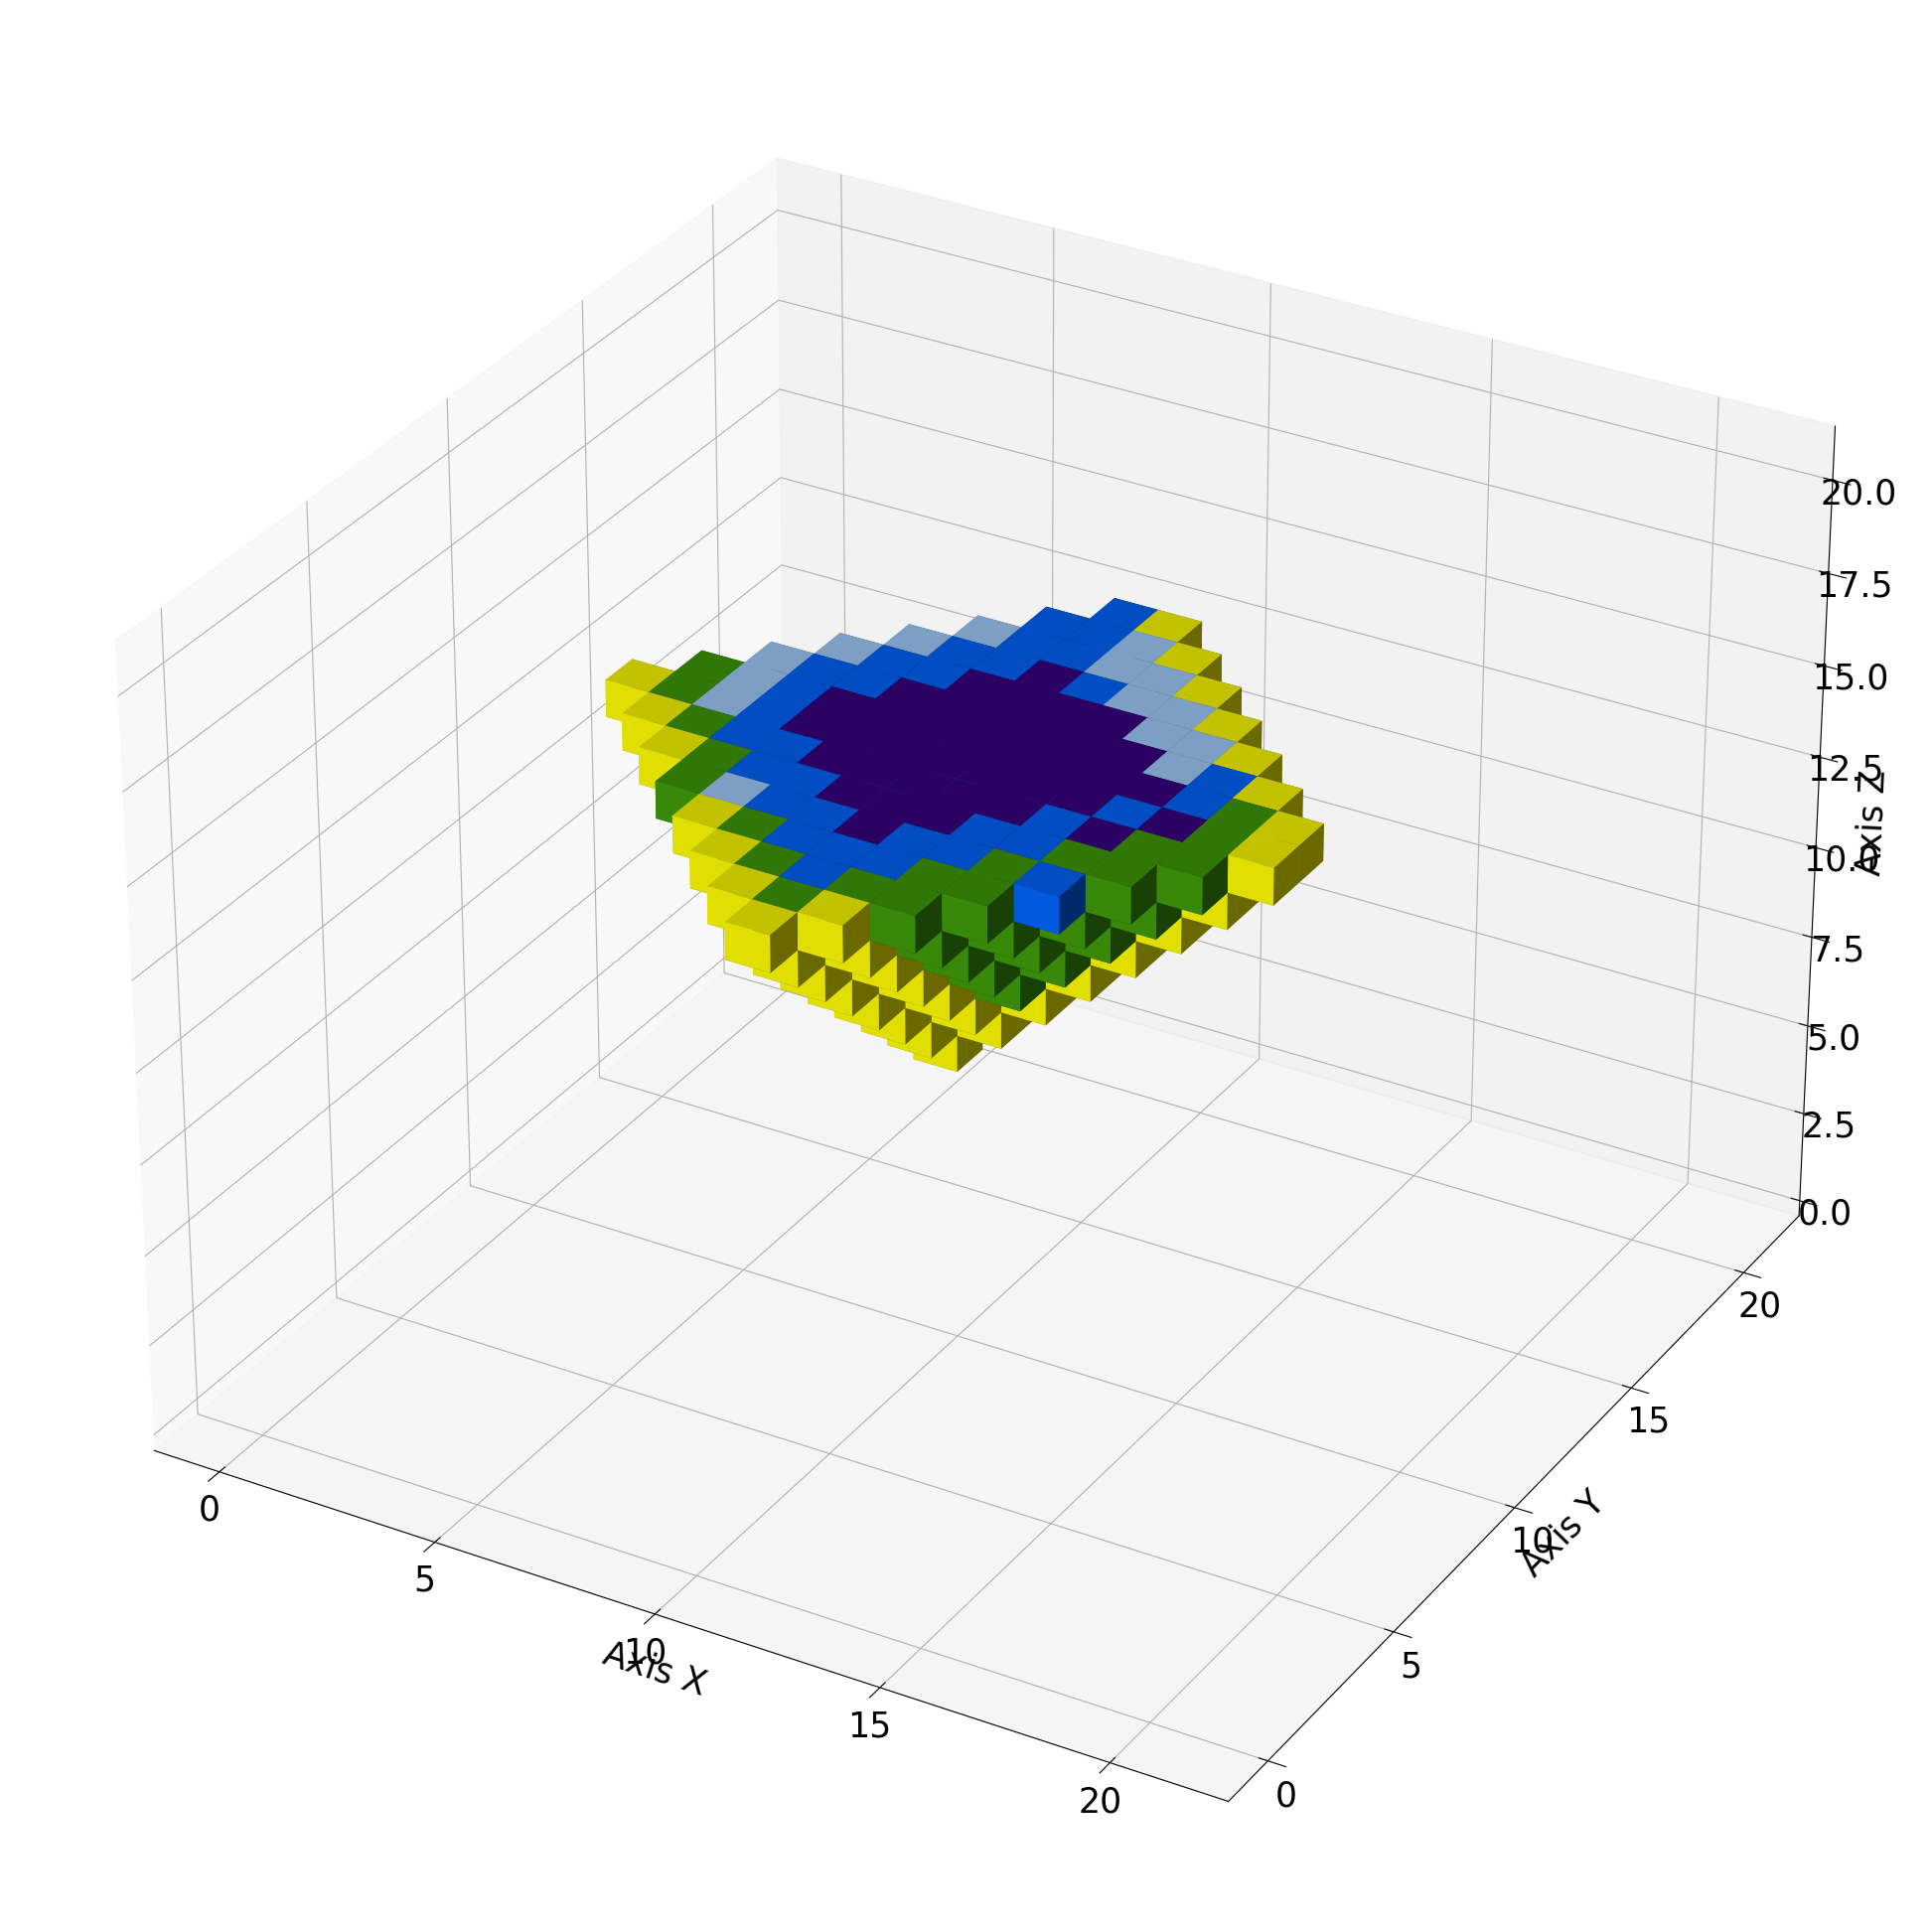

In [ ]:
plotResults(openPitVariableValues, openPitModel.openPitBlocks, openPitModel.openPitBlocksLengthLimits, openPitModel.openPitBlocksWidthLimits, openPitModel.openPitBlocksHeightLimits, openPitModel.openPitBlocksWidthLimits, openPitModel.openPitBlocksHeightLimits)